In [ ]:
import sys
sys.path.append("PATH_TO_SRC_DIR") # Replace with the actual path to your source directory

# Enable hot autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
from sklearn.metrics import roc_curve
import torch
from typing import Sequence
from collections import defaultdict
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaTokenizer, LlamaForCausalLM
from utils import compute_perplexity, ratio_auc, min_k_prob
import zlib

np.random.seed(42)

/home/matthieu/miniconda3/envs/canary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
OG_NON_MEMBER_PATH = "SOME_DATA_DIR/non_members.pickle"
OG_CANARY_PATH = "SOME_DATA_DIR/members.pickle"

LLAMA_TOKENIZER_PATH = "SOME_DATA_DIR/Llama-2-7b-hf/"
LLAMA_MODEL_PATH = "SOME_DATA_DIR/Llama-2-7b-hf/"

TARGET_MODEL = "EleutherAI/gpt-neo-1.3B"

## Let's just implement the MIA based on the original reference sequences for all T. 

In [4]:
llama_device = "cuda:1"
llama_tokenizer = LlamaTokenizer.from_pretrained(LLAMA_TOKENIZER_PATH, torch_dtype=torch.float16)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
#llama_model = LlamaForCausalLM.from_pretrained(LLAMA_MODEL_PATH).to(llama_device)

target_tokenizer = AutoTokenizer.from_pretrained(TARGET_MODEL)
target_tokenizer.pad_token = target_tokenizer.eos_token
target_device = "cuda:0"

In [5]:
# Let's get the canary text
with open(OG_CANARY_PATH, 'rb') as f:
    og_canaries = pickle.load(f)
    
og_canary_texts = [target_tokenizer.decode(og_canary) for og_canary in og_canaries]
og_canary_texts_lower = [x.lower() for x in og_canary_texts]

# and the non member text
with open(OG_NON_MEMBER_PATH, 'rb') as f:
    non_members = pickle.load(f)

non_member_texts = [target_tokenizer.decode(non_member) for non_member in non_members]
non_member_texts_lower = [x.lower() for x in non_member_texts]

What do we need for the AUC? 

So that's just using the croissant_T loss of the reference canary. 

And using the loss of the same croissant_T model on the non-members. 

In [6]:
def roc_auc(members: Sequence[float], non_members: Sequence[float]):
    y = []
    y_true = []

    y.extend(members)
    y.extend(non_members)

    y_true.extend([0] * len(members))
    y_true.extend([1] * len(non_members))

    fpr, tpr, _ = roc_curve(y_true, y)

    return fpr, tpr

In [7]:
def tpr_at_fpr(members, non_members, target_fpr):
    fpr, tpr = roc_auc(members, non_members)

    index = np.abs(fpr - target_fpr).argmin()
    return tpr[index]

In [8]:
def get_auc_with_bootstrapping(ratio_members, ratio_non_members, k=25):
    all_aucs = list()
    for _ in range(k):
        subset_members = np.random.choice(ratio_members, len(ratio_members))
        subset_non_members = np.random.choice(ratio_non_members, len(ratio_non_members))
        auc = ratio_auc(members=subset_members, non_members=subset_non_members)
        all_aucs.append(auc)
    return np.array(all_aucs)

In [9]:
def ppl_from_text(texts, model, tokenizer, device):
    tokens = tokenizer.batch_encode_plus(texts, return_tensors="pt", padding="longest").to(device)
    ppl = compute_perplexity(
        model,
        tokens.input_ids[:, 1:],
        tokens.attention_mask[:, 1:],
        ignore_prefix=None
    )

    return ppl

## Let's start with the scrambled n-grams

In [10]:
all_ns = [1, 2, 5, 10, 20, 50]
all_ns

[1, 2, 5, 10, 20, 50]

In [ ]:
n_scrambled_aucs = defaultdict(dict)

for n in all_ns:
    
    MODEL_CHECKPOINT_PATH = f"SOME_DATA_DIR/EleutherAI_gpt-neo-1.3B_checkpoints/EleutherAI_gpt-neo-1.3B_gptneo1B_near_duplicates_scrambled_n{n}_lr2e5"

    print("n=", n)

    score_members = {}
    score_non_members = {}
        
    target_model = AutoModelForCausalLM.from_pretrained(MODEL_CHECKPOINT_PATH).to(target_device)

    # first: non members
    print("Running on non members...")
    non_member_target_ppl = ppl_from_text(non_member_texts, target_model, target_tokenizer, target_device)
    non_member_llama_ppl = ppl_from_text(non_member_texts, llama_model, llama_tokenizer, llama_device)
    non_member_lower_target_ppl = ppl_from_text(non_member_texts_lower, target_model, target_tokenizer, target_device)

    target_tokens_non_members = target_tokenizer.batch_encode_plus(non_member_texts, return_tensors="pt", padding="longest").to(target_device)
    non_member_zlib_entropy = [len(zlib.compress(x.encode()))/len(x) for x in non_member_texts]
        
    score_non_members["ratio"] = non_member_target_ppl / non_member_llama_ppl
    score_non_members["loss"] = non_member_target_ppl
    score_non_members["lowercase"] = non_member_target_ppl / non_member_lower_target_ppl
    score_non_members["minkprob"] = -min_k_prob(target_model, target_tokens_non_members.input_ids, target_tokens_non_members.attention_mask)
    score_non_members["zlib"] = np.log(non_member_target_ppl) / non_member_zlib_entropy

    # now: non members
    print("Running on canaries...")
    og_canary_target_ppl = ppl_from_text(og_canary_texts, target_model, target_tokenizer, target_device)
    og_canary_llama_ppl = ppl_from_text(og_canary_texts, llama_model, llama_tokenizer, llama_device)
    og_canary_lower_target_ppl = ppl_from_text(og_canary_texts_lower, target_model, target_tokenizer, target_device)

    target_tokens_og_canary = target_tokenizer.batch_encode_plus(og_canary_texts, return_tensors="pt", padding="longest").to(target_device)
    og_canary_zlib_entropy = [len(zlib.compress(x.encode()))/len(x) for x in og_canary_texts]

    score_members["ratio"] = og_canary_target_ppl / og_canary_llama_ppl
    score_members["loss"] = og_canary_target_ppl
    score_members["lowercase"] = og_canary_target_ppl / og_canary_lower_target_ppl
    score_members["minkprob"] = -min_k_prob(target_model, target_tokens_og_canary.input_ids, target_tokens_og_canary.attention_mask)
    score_members["zlib"] = np.log(og_canary_target_ppl) / og_canary_zlib_entropy

    for mia in score_members:
        aucs = get_auc_with_bootstrapping(ratio_members=score_members[mia], ratio_non_members=score_non_members[mia])
        tpr_at = tpr_at_fpr(score_members[mia], score_non_members[mia], target_fpr=0.1)
        print(f"n={n}, MIA={mia}, AUC = {np.mean(aucs):.2f} ± {np.std(aucs):.2f}, TPR @ 0.1 FPR = {tpr_at:.2f}")
        n_scrambled_aucs[n][mia] = aucs
    print("-------------------")

n= 1


Loading checkpoint shards: 100%|██████████| 2/2 [00:24<00:00, 12.28s/it]


Running on non members...
Running on canaries...
n=1, MIA=ratio, AUC = 0.73 ± 0.03, TPR @ 0.1 FPR = 0.38
n=1, MIA=loss, AUC = 0.69 ± 0.03, TPR @ 0.1 FPR = 0.28
n=1, MIA=lowercase, AUC = 0.60 ± 0.05, TPR @ 0.1 FPR = 0.18
n=1, MIA=minkprob, AUC = 0.74 ± 0.04, TPR @ 0.1 FPR = 0.24
n=1, MIA=zlib, AUC = 0.64 ± 0.04, TPR @ 0.1 FPR = 0.18
-------------------
n= 2


Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.46s/it]


Running on non members...
Running on canaries...
n=2, MIA=ratio, AUC = 0.76 ± 0.03, TPR @ 0.1 FPR = 0.47
n=2, MIA=loss, AUC = 0.70 ± 0.04, TPR @ 0.1 FPR = 0.40
n=2, MIA=lowercase, AUC = 0.61 ± 0.04, TPR @ 0.1 FPR = 0.22
n=2, MIA=minkprob, AUC = 0.77 ± 0.04, TPR @ 0.1 FPR = 0.39
n=2, MIA=zlib, AUC = 0.68 ± 0.05, TPR @ 0.1 FPR = 0.35
-------------------
n= 5


Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.77s/it]


Running on non members...
Running on canaries...
n=5, MIA=ratio, AUC = 0.83 ± 0.03, TPR @ 0.1 FPR = 0.44
n=5, MIA=loss, AUC = 0.76 ± 0.03, TPR @ 0.1 FPR = 0.48
n=5, MIA=lowercase, AUC = 0.63 ± 0.04, TPR @ 0.1 FPR = 0.24
n=5, MIA=minkprob, AUC = 0.80 ± 0.03, TPR @ 0.1 FPR = 0.40
n=5, MIA=zlib, AUC = 0.73 ± 0.04, TPR @ 0.1 FPR = 0.44
-------------------
n= 10


Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.99s/it]


Running on non members...
Running on canaries...
n=10, MIA=ratio, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.62
n=10, MIA=loss, AUC = 0.81 ± 0.03, TPR @ 0.1 FPR = 0.50
n=10, MIA=lowercase, AUC = 0.65 ± 0.04, TPR @ 0.1 FPR = 0.24
n=10, MIA=minkprob, AUC = 0.85 ± 0.03, TPR @ 0.1 FPR = 0.57
n=10, MIA=zlib, AUC = 0.78 ± 0.03, TPR @ 0.1 FPR = 0.53
-------------------
n= 20


Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.99s/it]


Running on non members...
Running on canaries...
n=20, MIA=ratio, AUC = 0.92 ± 0.02, TPR @ 0.1 FPR = 0.78
n=20, MIA=loss, AUC = 0.86 ± 0.03, TPR @ 0.1 FPR = 0.71
n=20, MIA=lowercase, AUC = 0.66 ± 0.04, TPR @ 0.1 FPR = 0.30
n=20, MIA=minkprob, AUC = 0.89 ± 0.02, TPR @ 0.1 FPR = 0.74
n=20, MIA=zlib, AUC = 0.83 ± 0.02, TPR @ 0.1 FPR = 0.65
-------------------
n= 50


Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.35s/it]


Running on non members...
Running on canaries...
n=50, MIA=ratio, AUC = 0.95 ± 0.01, TPR @ 0.1 FPR = 0.87
n=50, MIA=loss, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.80
n=50, MIA=lowercase, AUC = 0.70 ± 0.04, TPR @ 0.1 FPR = 0.34
n=50, MIA=minkprob, AUC = 0.93 ± 0.02, TPR @ 0.1 FPR = 0.81
n=50, MIA=zlib, AUC = 0.88 ± 0.03, TPR @ 0.1 FPR = 0.74
-------------------


In [ ]:
with open(".SOME_DATA_DIR/results_n_gram_scrambled.pickle", "wb") as f:
    pickle.dump(n_scrambled_aucs, f)
    
with open("SOME_DATA_DIR/results_n_gram_scrambled.pickle", "rb") as f:
    n_scrambled_aucs = pickle.load(f)  

## Now the insertions

In [ ]:
X_insertions = 10

n_insert10_aucs = defaultdict(dict)

for n in all_ns:
    
    MODEL_CHECKPOINT_PATH = f"SOME_DATA_DIR/model_checkpoints/EleutherAI_gpt-neo-1.3B_checkpoints/EleutherAI_gpt-neo-1.3B_gptneo1B_near_duplicates_insertionX={X_insertions}_n{n}_lr2e5"

    print("n=", n)

    score_members = {}
    score_non_members = {}
        
    target_model = AutoModelForCausalLM.from_pretrained(MODEL_CHECKPOINT_PATH).to(target_device)

    # first: non members
    print("Running on non members...")
    non_member_target_ppl = ppl_from_text(non_member_texts, target_model, target_tokenizer, target_device)
    non_member_llama_ppl = ppl_from_text(non_member_texts, llama_model, llama_tokenizer, llama_device)
    non_member_lower_target_ppl = ppl_from_text(non_member_texts_lower, target_model, target_tokenizer, target_device)

    target_tokens_non_members = target_tokenizer.batch_encode_plus(non_member_texts, return_tensors="pt", padding="longest").to(target_device)
    non_member_zlib_entropy = [len(zlib.compress(x.encode()))/len(x) for x in non_member_texts]
        
    score_non_members["ratio"] = non_member_target_ppl / non_member_llama_ppl
    score_non_members["loss"] = non_member_target_ppl
    score_non_members["lowercase"] = non_member_target_ppl / non_member_lower_target_ppl
    score_non_members["minkprob"] = -min_k_prob(target_model, target_tokens_non_members.input_ids, target_tokens_non_members.attention_mask)
    score_non_members["zlib"] = np.log(non_member_target_ppl) / non_member_zlib_entropy

    # now: non members
    print("Running on canaries...")
    og_canary_target_ppl = ppl_from_text(og_canary_texts, target_model, target_tokenizer, target_device)
    og_canary_llama_ppl = ppl_from_text(og_canary_texts, llama_model, llama_tokenizer, llama_device)
    og_canary_lower_target_ppl = ppl_from_text(og_canary_texts_lower, target_model, target_tokenizer, target_device)

    target_tokens_og_canary = target_tokenizer.batch_encode_plus(og_canary_texts, return_tensors="pt", padding="longest").to(target_device)
    og_canary_zlib_entropy = [len(zlib.compress(x.encode()))/len(x) for x in og_canary_texts]

    score_members["ratio"] = og_canary_target_ppl / og_canary_llama_ppl
    score_members["loss"] = og_canary_target_ppl
    score_members["lowercase"] = og_canary_target_ppl / og_canary_lower_target_ppl
    score_members["minkprob"] = -min_k_prob(target_model, target_tokens_og_canary.input_ids, target_tokens_og_canary.attention_mask)
    score_members["zlib"] = np.log(og_canary_target_ppl) / og_canary_zlib_entropy

    for mia in score_members:
        aucs = get_auc_with_bootstrapping(ratio_members=score_members[mia], ratio_non_members=score_non_members[mia])
        tpr_at = tpr_at_fpr(score_members[mia], score_non_members[mia], target_fpr=0.1)
        print(f"n={n}, MIA={mia}, AUC = {np.mean(aucs):.2f} ± {np.std(aucs):.2f}, TPR @ 0.1 FPR = {tpr_at:.2f}")
        n_insert10_aucs[n][mia] = aucs
    print("-------------------")

n= 1


Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.21s/it]


Running on non members...
Running on canaries...
n=1, MIA=ratio, AUC = 0.71 ± 0.03, TPR @ 0.1 FPR = 0.37
n=1, MIA=loss, AUC = 0.65 ± 0.03, TPR @ 0.1 FPR = 0.29
n=1, MIA=lowercase, AUC = 0.58 ± 0.04, TPR @ 0.1 FPR = 0.20
n=1, MIA=minkprob, AUC = 0.68 ± 0.04, TPR @ 0.1 FPR = 0.23
n=1, MIA=zlib, AUC = 0.63 ± 0.04, TPR @ 0.1 FPR = 0.22
-------------------
n= 2


Loading checkpoint shards: 100%|██████████| 2/2 [00:21<00:00, 10.56s/it]


Running on non members...
Running on canaries...
n=2, MIA=ratio, AUC = 0.77 ± 0.04, TPR @ 0.1 FPR = 0.45
n=2, MIA=loss, AUC = 0.69 ± 0.04, TPR @ 0.1 FPR = 0.31
n=2, MIA=lowercase, AUC = 0.59 ± 0.04, TPR @ 0.1 FPR = 0.23
n=2, MIA=minkprob, AUC = 0.73 ± 0.03, TPR @ 0.1 FPR = 0.29
n=2, MIA=zlib, AUC = 0.67 ± 0.03, TPR @ 0.1 FPR = 0.28
-------------------
n= 5


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.19s/it]


Running on non members...
Running on canaries...
n=5, MIA=ratio, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.73
n=5, MIA=loss, AUC = 0.81 ± 0.02, TPR @ 0.1 FPR = 0.58
n=5, MIA=lowercase, AUC = 0.63 ± 0.02, TPR @ 0.1 FPR = 0.27
n=5, MIA=minkprob, AUC = 0.84 ± 0.03, TPR @ 0.1 FPR = 0.49
n=5, MIA=zlib, AUC = 0.80 ± 0.04, TPR @ 0.1 FPR = 0.58
-------------------
n= 10


Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.64s/it]


Running on non members...
Running on canaries...
n=10, MIA=ratio, AUC = 0.94 ± 0.01, TPR @ 0.1 FPR = 0.82
n=10, MIA=loss, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.72
n=10, MIA=lowercase, AUC = 0.68 ± 0.05, TPR @ 0.1 FPR = 0.29
n=10, MIA=minkprob, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.81
n=10, MIA=zlib, AUC = 0.85 ± 0.03, TPR @ 0.1 FPR = 0.68
-------------------
n= 20


Loading checkpoint shards: 100%|██████████| 2/2 [00:26<00:00, 13.33s/it]


Running on non members...
Running on canaries...
n=20, MIA=ratio, AUC = 0.96 ± 0.02, TPR @ 0.1 FPR = 0.90
n=20, MIA=loss, AUC = 0.90 ± 0.02, TPR @ 0.1 FPR = 0.74
n=20, MIA=lowercase, AUC = 0.69 ± 0.04, TPR @ 0.1 FPR = 0.34
n=20, MIA=minkprob, AUC = 0.93 ± 0.02, TPR @ 0.1 FPR = 0.89
n=20, MIA=zlib, AUC = 0.88 ± 0.02, TPR @ 0.1 FPR = 0.73
-------------------
n= 50


Loading checkpoint shards: 100%|██████████| 2/2 [00:24<00:00, 12.13s/it]


Running on non members...
Running on canaries...
n=50, MIA=ratio, AUC = 0.97 ± 0.01, TPR @ 0.1 FPR = 0.91
n=50, MIA=loss, AUC = 0.92 ± 0.02, TPR @ 0.1 FPR = 0.84
n=50, MIA=lowercase, AUC = 0.73 ± 0.03, TPR @ 0.1 FPR = 0.36
n=50, MIA=minkprob, AUC = 0.94 ± 0.02, TPR @ 0.1 FPR = 0.89
n=50, MIA=zlib, AUC = 0.91 ± 0.02, TPR @ 0.1 FPR = 0.77
-------------------


In [ ]:
with open("SOME_DATA_DIR/results_n_gram_insert10.pickle", "wb") as f:
    pickle.dump(n_insert10_aucs, f)
    
with open("SOME_DATA_DIR/results_n_gram_insert10.pickle", "rb") as f:
    n_insert10_aucs = pickle.load(f)

## Now let's create the figure

In [11]:
def compute_rho(phi_fuz: float, phi_exact: dict):

    lambda_ = None
    max_key = max(phi_exact.keys())
    
    # first if the target is smaller than the smallest for exact
    if phi_fuz <= phi_exact[1]:
        lambda_ = 1
        return lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_+1] - phi_exact[lambda_])
    
    # then if the target is larger than the larger for exact
    elif phi_fuz >= phi_exact[max_key]:
        lambda_ = max_key
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_] - phi_exact[lambda_ - 1])
    
    # do interpolation otherwise
    else:
        for n in range(1, max_key):
            if phi_exact[n] <= phi_fuz and phi_exact[n+1] >= phi_fuz:
                lambda_ = n
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_ + 1] - phi_exact[lambda_])
        
    return (neq - 1) / 9.0
  
def smooth_curve(nrep_aucs, mia = 'ratio', window_size=3):
    
    original_values =  [np.mean(nrep_aucs[n][mia]) for n in range(1,max(nrep_aucs.keys())+1)]

    # Apply a moving average with a window of 3
    smoothed_values = np.convolve(original_values, np.ones(window_size) / window_size, mode='valid')

    # Extend smoothed values to match original length
    smoothed_values = np.concatenate(([original_values[0]], smoothed_values, [original_values[-1]]))
        
    return {n:smoothed_values[i] for i, n in enumerate(range(1,max(nrep_aucs.keys())+1))}

In [ ]:
# and also the exact duplicates
with open("SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_lr2e5.pickle", "rb") as f:
   nrep_aucs = pickle.load(f)
   
all_mias = ('loss', 'ratio', 'lowercase', 'minkprob', 'zlib')

all_phi_exact = dict()

for mia in all_mias:
    all_phi_exact[mia] = smooth_curve(nrep_aucs, mia=mia, window_size=3)

In [ ]:
all_insert_results = {}

for X in (1, 5, 10):
    with open(f"SOME_DATA_DIR/results_n_gram_insert{X}.pickle", "rb") as f:
        all_insert_results[X] = pickle.load(f)
        
# also open the scrambled
with open("SOME_DATA_DIR/results_n_gram_scrambled.pickle", "rb") as f:
    all_scrambled_results = pickle.load(f)

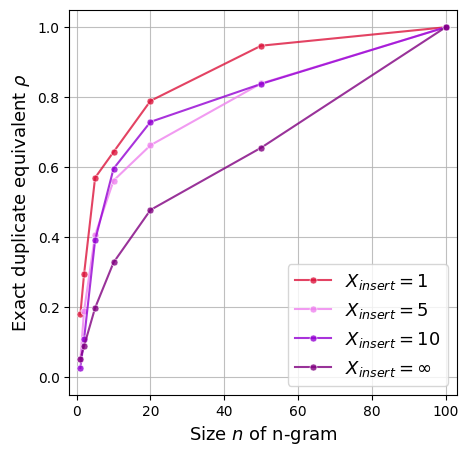

In [26]:
import matplotlib.pyplot as plt

mia = 'ratio'
colors = ['crimson', 'violet', 'darkviolet']

plt.figure(figsize = (5, 5))

# let's start with the ngram insertions
for i, X in enumerate((1, 5, 10)):
    n_aucs = all_insert_results[X]
    rho_to_plot = dict()
    for n in n_aucs:
        rho_to_plot[n] = compute_rho(phi_fuz=np.mean(n_aucs[n][mia]), phi_exact=all_phi_exact[mia])
            
    plt.plot(all_ns + [100], [rho_to_plot[n] for n in all_ns] + [1], '-o', color=colors[i], markersize=5, alpha=0.8, 
                markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5, label = f"$X_{{insert}}={X}$")
    
# let's do the scrambled
n_aucs = all_scrambled_results
rho_to_plot = dict()
for n in n_aucs:
    rho_to_plot[n] = compute_rho(phi_fuz=np.mean(n_aucs[n][mia]), phi_exact=all_phi_exact[mia])
plt.plot(all_ns + [100], [rho_to_plot[n] for n in all_ns] + [1], '-o', color='purple', markersize=5, alpha=0.8, 
                markeredgecolor='white', markerfacecolor='purple', markeredgewidth=0.5, label = f"$X_{{insert}}=\infty$")

plt.xlabel(r'Size $n$ of n-gram', fontsize = 13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize = 13)
plt.legend(fontsize = 13, loc='lower right')
plt.grid(alpha = 0.8)
plt.ylim(-0.05, 1.05)
plt.xlim(-2, 103)
plt.show()